<a href="https://colab.research.google.com/github/AlphaLock/Classification-Project-Predicting-Customer-Churn/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJECT SCENARIO

In this times series project, we will build a model that predicts the unit sales for thousands of items sold at Corporation Favorita, a large Ecuadorian-based grocery retailer.

## PROJECT DESCRIPTION

In this project, we will analyze past sales data from Corporation Favorita. Also, we will analyze other occurrences that may have impact on the sales performance of the retail store chains.

Also, we will build different machine learning models, evaluate the models, test the models, compare performances of the models and select the model that best predicts future grocery sales.

## BUSINESS QUESTIONS

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

#### ADDITIONAL QUESTION
8. Is there a significant difference in sales during holidays versus non-holidays?
9. Do stores located in certain locales have higher holiday sales compared to others?
10. Do stores in certain cities or states have higher sales compared to others?
11. Is there a difference in transactions during holidays versus non-holidays?
12. Does the promotion of certain items during holidays impact sales?

### IMPORT LIBRARIES FOR PROJECT

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import interpolate

import os, pickle
import sklearn


import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

### IMPORT PROJECT DATASETS

In [ ]:
train = pd.read_csv("train.csv",
                    dtype={'store_nbr': 'int8','family': 'category','sales': 'float32','onpromotion': 'uint32'},
                    low_memory=False)

test = pd.read_csv("test.csv")

stores = pd.read_csv("stores.csv")

holidays = pd.read_csv("holidays_events.csv")

oil = pd.read_csv("oil.csv")

transactions = pd.read_csv("transactions.csv")

sample = pd.read_csv("sample_submission.csv")


## EXPLORATORY DATA ANALYSIS

#### EXPLORING THE TRAIN DATASET

In [ ]:
# Checking the head and tail of the train data

train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


In [ ]:
# Checking the size of the train dataset

train.shape

(3000888, 6)

The train dataset has 3000888 rows and 6 colums

In [ ]:
# Checking the basic info of the train data

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype   
---  ------       -----   
 0   id           int64   
 1   date         object  
 2   store_nbr    int8    
 3   family       category
 4   sales        float32 
 5   onpromotion  uint32  
dtypes: category(1), float32(1), int64(1), int8(1), object(1), uint32(1)
memory usage: 74.4+ MB


The date column is recorded as object. It has to be converted to date format

In [ ]:
# Checking for null values in the train data

train.isnull().any()

id             False
date           False
store_nbr      False
family         False
sales          False
onpromotion    False
dtype: bool

 There are no null values in the train dataset

In [ ]:
# Checking for missing data in the train dataset

train.duplicated().any()

False

There are no duplicated values in the train dataset

In [ ]:
# Checking the basic statistics of the train data

train.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3000888.0,NaN,NaN,NaN,1500443.5,866281.891642,0.0,750221.75,1500443.5,2250665.25,3000887.0
date,3000888,1684,2013-01-01,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_nbr,3000888.0,NaN,NaN,NaN,27.5,15.585787,1.0,14.0,27.5,41.0,54.0
family,3000888,33,AUTOMOTIVE,90936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.0,NaN,NaN,NaN,357.775787,1101.997681,0.0,0.0,11.0,195.847252,124717.0
onpromotion,3000888.0,NaN,NaN,NaN,2.60277,12.218882,0.0,0.0,0.0,0.0,741.0


There are 33 different categories of grocery products. Automotive family has the most number of products.<br />Also, there are 54 stores in the data

#### EXPLORING THE TEST DATASET

In [ ]:
# Checking the head and tail of the test data

test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [ ]:
# Checking the sahpe of the test dataset

test.shape

(28512, 5)

There are 2852 rows and 5 columns. It is noted that the sales column has been removed form the test data

In [ ]:
# Checking the basic info of the test data

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


There are no null values, the date column is recorded as an pbject.

In [ ]:
# Checking for duplicates in the test data

test.duplicated().any()

False

There are no duplicated values in the test data

In [ ]:
# Checking for unique values in the test data

test.nunique()

id             28512
date              16
store_nbr         54
family            33
onpromotion      212
dtype: int64

There are 16 days recorded, 54 stores and 33 different product families

#### EXPLORING THE STORES DATA

In [ ]:
# Checking the head  of the stores data

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
# Checking the shape of the stores data

stores.shape

(54, 5)

There are 54 rows and 5 columns in the stores data

In [ ]:
# Checking the basic info of the stores data

stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


There are no null entries in the stores data

In [ ]:
# Checking for dupliated entries in the stores data

stores.duplicated().any()

False

There are no duplicated entries in the stores data

In [ ]:
# Checking for unique values in the stores data

stores.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

Stores are located at 22 different Cities in 16 States. There are 5 different types of stores.There are 17 similar stores located in these cities.

#### EXPLORING THE HOLIDAYS DATA

In [ ]:
# Checking the head of the holidays data

holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# Checking the basic info of the holidays data

holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


The date column is recorded as object. This will be changed to the date format. There are no null values in the data.

In [ ]:
# Checking for duplicated values in the data

holidays.duplicated().any()

False

There are no duplicated values in the holidays dataset

In [ ]:
# Checking the number of unique values in the holidays dataset

holidays.nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

There are 6 types of holidays and 2 forms of holidays transfers

In [ ]:
# Checking the different types of holidays

list(holidays.type.unique())

['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event']

#### EXPLORING THE OIL DATA

In [ ]:
# Checking the head of the oil data

oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [ ]:
# Checking the shape of the oil data

oil.shape

(1218, 2)

There are 1218 ros and 2 columns

In [ ]:
# Checking the basic info of the oil data

oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


The date is in object format. It must corrected to date format. There are null 

In [ ]:
# Checking the null values

oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

There are 43 null values in the oil data. Since this a crude oil price,, there is no possibilty that crude oil price will 0. Hence, we will compute it with either the mean, minimum value or 50th percentile

In [ ]:
# Cecking for duplicated values in the oil data

oil.duplicated().any()

False

There are no duplicated values in the oil data

In [ ]:
# Checking the basic statistics of the oil data

oil.describe(exclude="object").transpose()

,count,mean,std,min,25%,50%,75%,max
dcoilwtico,1175.0,67.714366,25.630476,26.19,46.405,53.19,95.66,110.62


#### EXPLORING THE TRANSACTIONS DATASET

In [ ]:
# Checking the head of the transactions data

transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [ ]:
# Checking the shape of the transactions data

transactions.shape

(83488, 3)

There are 834888 rows and 3 columns in the transactions data

In [ ]:
# Checking the basic info of the transactions data

transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


The date is not in the correct format. It is recorded in object. We will convert it to date format. There are no null values in the data.

In [ ]:
# Checking for duplicated values in the transactions data

transactions.duplicated().any()

False

There are no duplicated values in the data.

### UNIVARIATE ANALYSIS

#### VISUALLY EXPOLRING SALES OVER TIME FROM THE TRAIN DATA

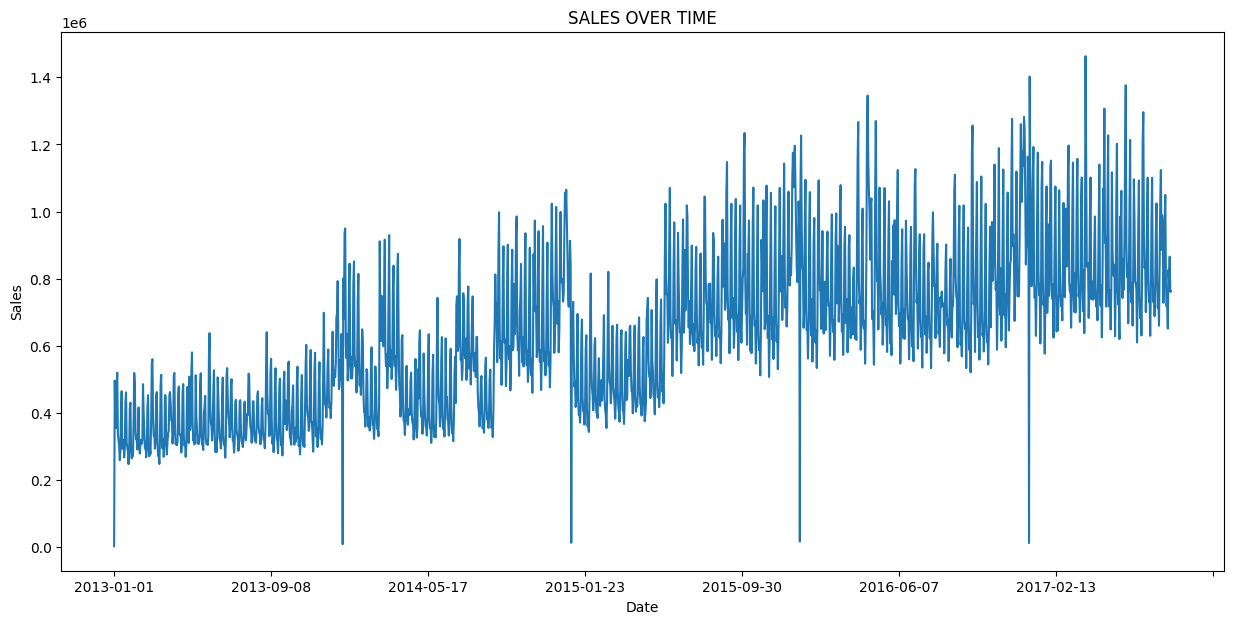

In [ ]:
sales_time = train.groupby("date").sales.sum().reset_index()
sales_time = sales_time.set_index("date")

sales_time.plot(legend=False, figsize=(15, 7))
plt.title("SALES OVER TIME")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.style.use("fivethirtyeight")
plt.show()

It can be analyzed there is an increasing sales trend from year to year

### VISUALLY EXPLORING TRANSACTIONS BY DATE

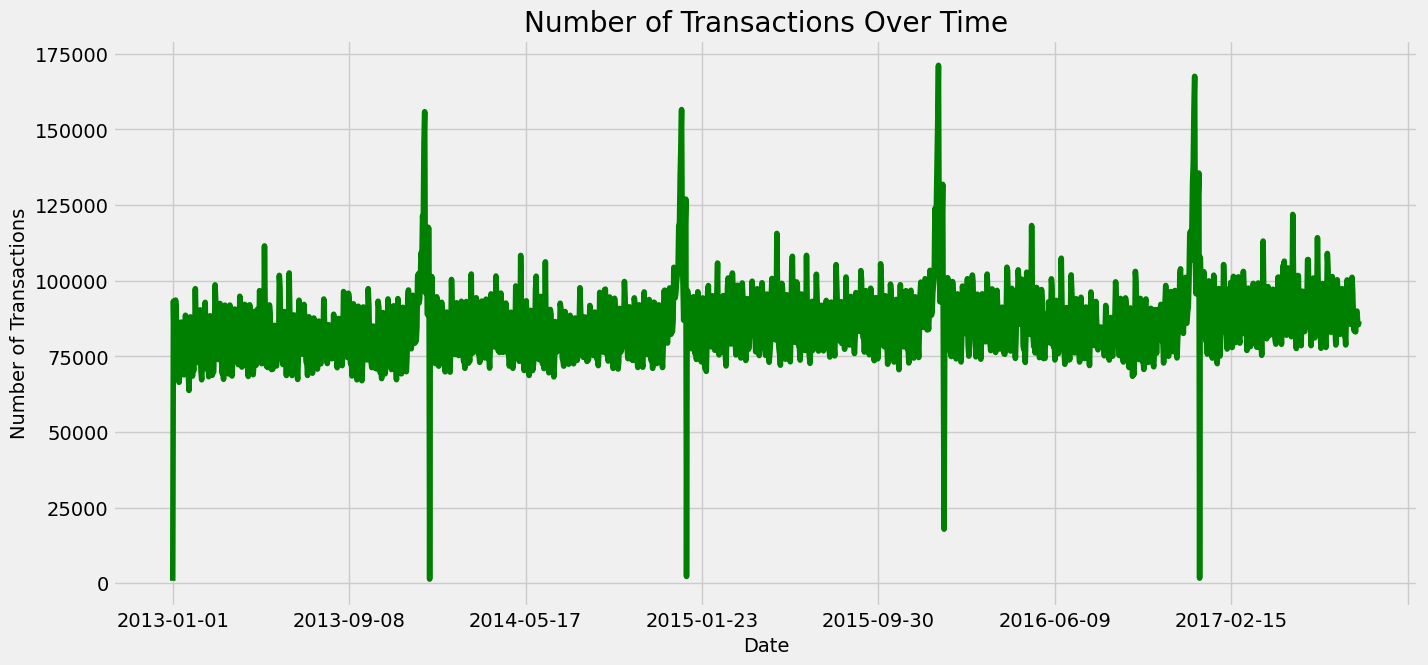

In [ ]:
transactions_date = transactions.groupby('date').transactions.sum().reset_index()
transactions_date = transactions_date.set_index("date")

transactions_date.plot(legend=False, color="green", figsize=(15, 7))
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.style.use("fivethirtyeight")
plt.show()

Transactions were stationary throughout the recorded years. With the exception, of the ends of the years where there are sharp increases in transactions showing seasonality.

### VISUALLY EXPLORING THE OIL DATA

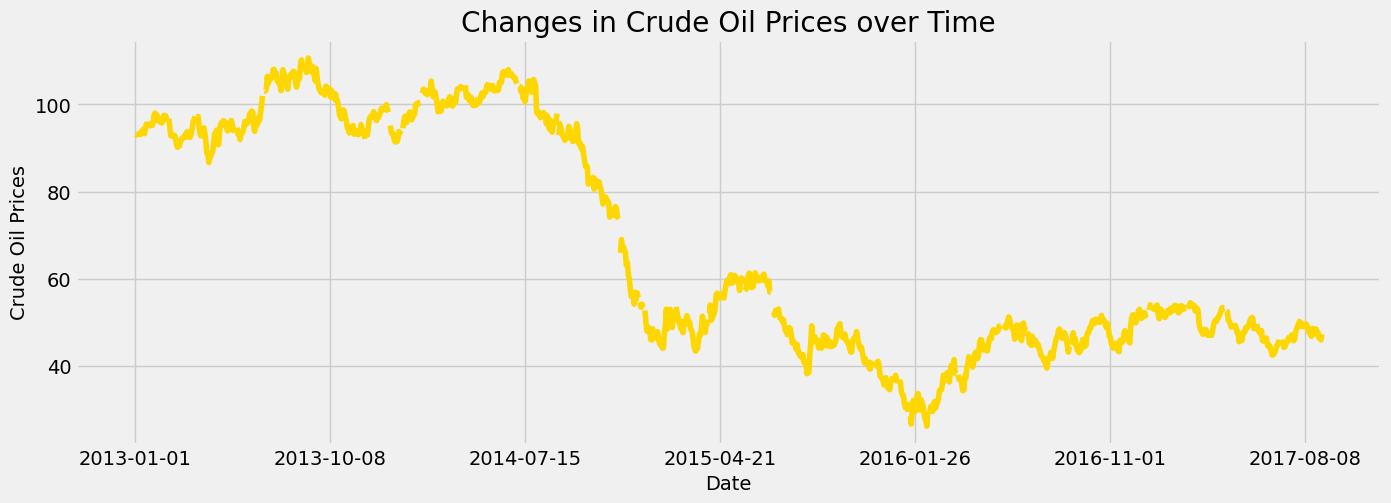

In [ ]:
oil.set_index("date")

oil.plot(x="date", y="dcoilwtico", color="gold", legend=False, figsize=(15, 5))
plt.title('Changes in Crude Oil Prices over Time')
plt.xlabel('Date')
plt.ylabel('Crude Oil Prices')
plt.style.use("fivethirtyeight")
plt.show()

This shows a decreasing trend in the prices of Crude oil prices on thw world market. Later on, we shall find out if these prices decreases affect affect sales.<br />Also, breaks in the trend show missing values

### VISUALLY EXPLORING STORES DATA

In [ ]:
stores.set_index("store_nbr").head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
stores = stores["type"].value_counts()
stores

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

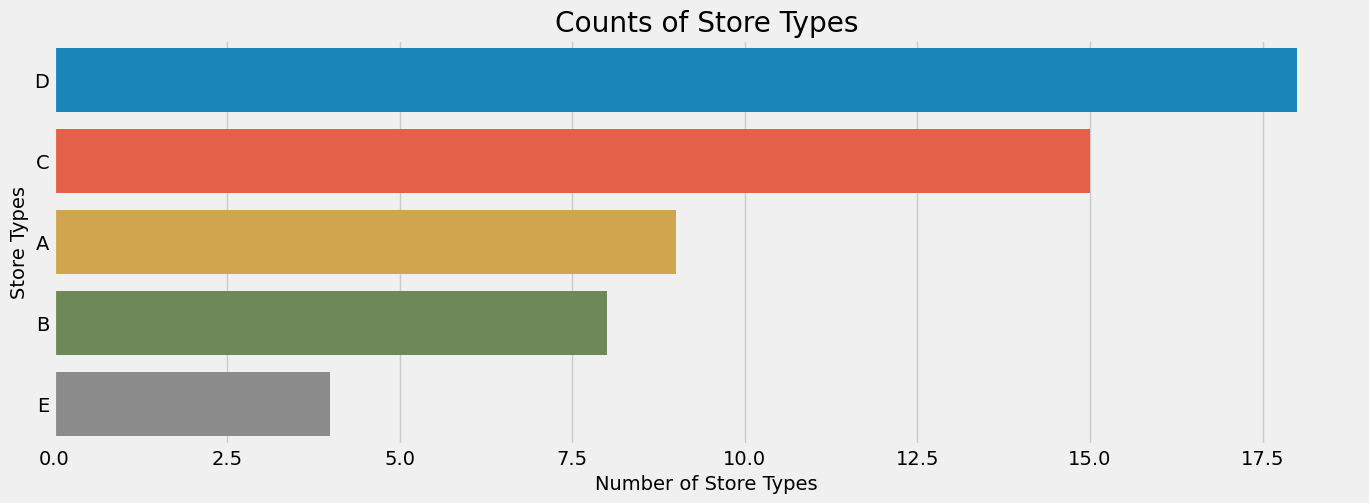

In [ ]:
plt.figure(figsize=(15, 5))

sns.barplot(x=stores.values, y=stores.index)
plt.title('Counts of Store Types')
plt.ylabel('Store Types')
plt.xlabel("Number of Store Types")
plt.style.use("fivethirtyeight")
plt.show()


From the chart, Stores category D has the largest number of chains, followed by Stores Category C. Stores Category E has the lowest number of store chains.

### EXPLORING THE HOLIDAY DATA

In [ ]:
# Checking holidays that were transferred

holidays[holidays.transferred == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


These were holidays that were transferred to other dates

In [ ]:
# Checking corresponding dates on which holidays were transferred to

holidays[holidays.type == "Transfer"]

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False



These were that transferred holidays were observed

In [ ]:
# Checking "Holidays" that were celebrated on actual days and not transferred

holidays[(holidays.type == "Holiday") & (holidays.transferred == False)]

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
337,2017-11-11,Holiday,Local,Latacunga,Independencia de Latacunga,False
338,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False


Theses holidays were not transferred but were celebrated on their actual days

In [ ]:
# Checking  Bridge holidays

holidays[holidays.type == "Bridge"]

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False


These were days that that were added holidays to extend the break across a long holiday weekend

In [ ]:
# Checking for Work days

holidays[holidays.type == "Work Day"]

,date,type,locale,locale_name,description,transferred
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


These were non-working days that observed as working days to pay back for the bridge

In [ ]:
# Checking additional holidays

holidays[holidays.type == "Additional"]

,date,type,locale,locale_name,description,transferred
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False
64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False
81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False


These are additional days added to regular calendar holidays.

In [ ]:
holidays[holidays.type == "Event"]

,date,type,locale,locale_name,description,transferred
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
114,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False


These were days observed for special events

### BIVARIATE ANALYSIS

#### Checking for the relationship between oil price and sales

In [ ]:
sales = train.groupby("date").sales.sum()

In [ ]:
oil_sales = pd.merge(sales, oil, on="date", how="left")
oil_sales = oil_sales.rename(columns={"dcoilwtico" : "oil_price"})
oil_sales = oil_sales.set_index("date").dropna()
oil_sales.head()

,sales,oil_price
date,,
2013-01-02,496092.40625,93.14
2013-01-03,361461.21875,92.97
2013-01-04,354459.68750,93.12
2013-01-07,336122.81250,93.20
2013-01-08,318347.78125,93.21


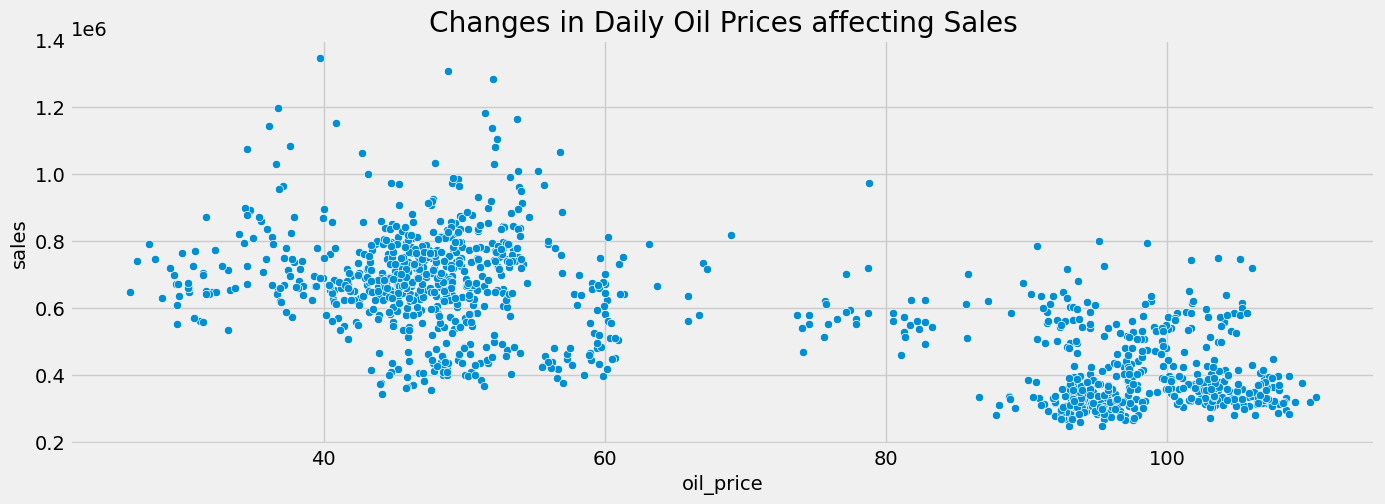

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=oil_sales, x="oil_price", y="sales", palette="Blues_r", legend=False)
plt.title("Changes in Daily Oil Prices affecting Sales")
plt.show()


From the sccatter plot, it can be realized that the relationship between oil price and sales is negatively correlated. As oil prices increase, sales reduces.

#### Transactions and Sales

In [ ]:
Transactions = transactions.groupby("date").sum().drop("store_nbr", axis=1)
Transactions_Sales = pd.merge(Transactions, sales, on="date", how="left")
Transactions_Sales.head()

,transactions,sales
date,,
2013-01-01,770,2511.618896
2013-01-02,93215,496092.406250
2013-01-03,78504,361461.218750
2013-01-04,78494,354459.687500
2013-01-05,93573,477350.125000


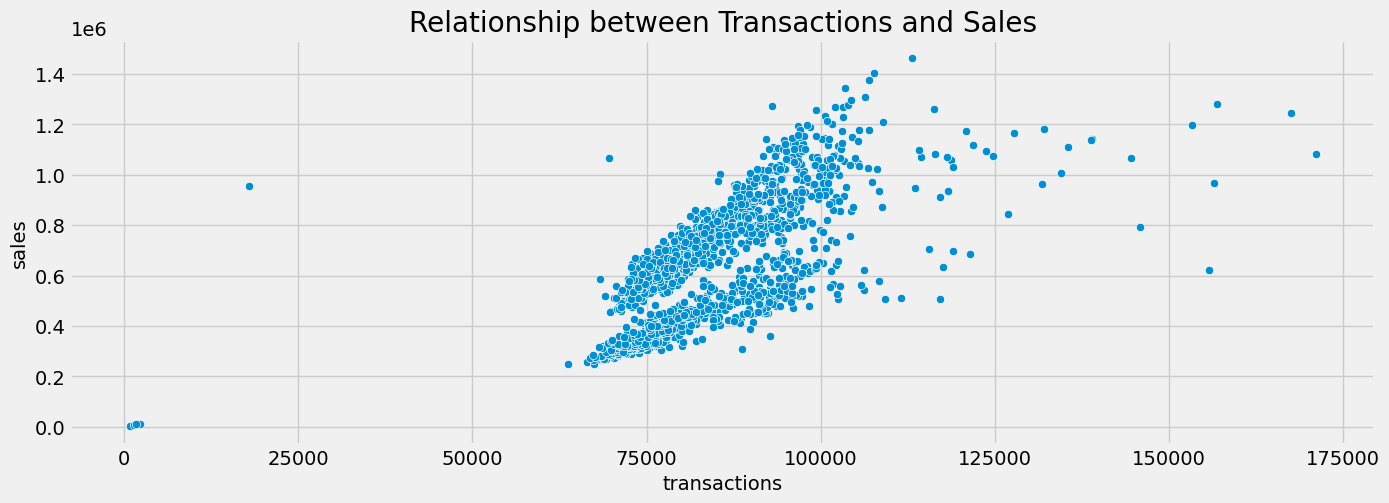

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=Transactions_Sales, x="transactions", y="sales", palette="Blues_r", legend=False)
plt.title("Relationship between Transactions and Sales")
plt.show()


From the plot, sales and trasactions at different stores have a positive correlation. Generally, as transactions at the different stores increase, so does sales.

#### Transactions and oil

In [ ]:
Oil_Transactions = pd.merge(Transactions, oil, on="date", how="left").dropna()
Oil_Transactions = Oil_Transactions.rename(columns={"dcoilwtico" : "oil_price"})
Oil_Transactions.head()

,date,transactions,oil_price
1,2013-01-02,93215,93.14
2,2013-01-03,78504,92.97
3,2013-01-04,78494,93.12
6,2013-01-07,75597,93.20
7,2013-01-08,72325,93.21


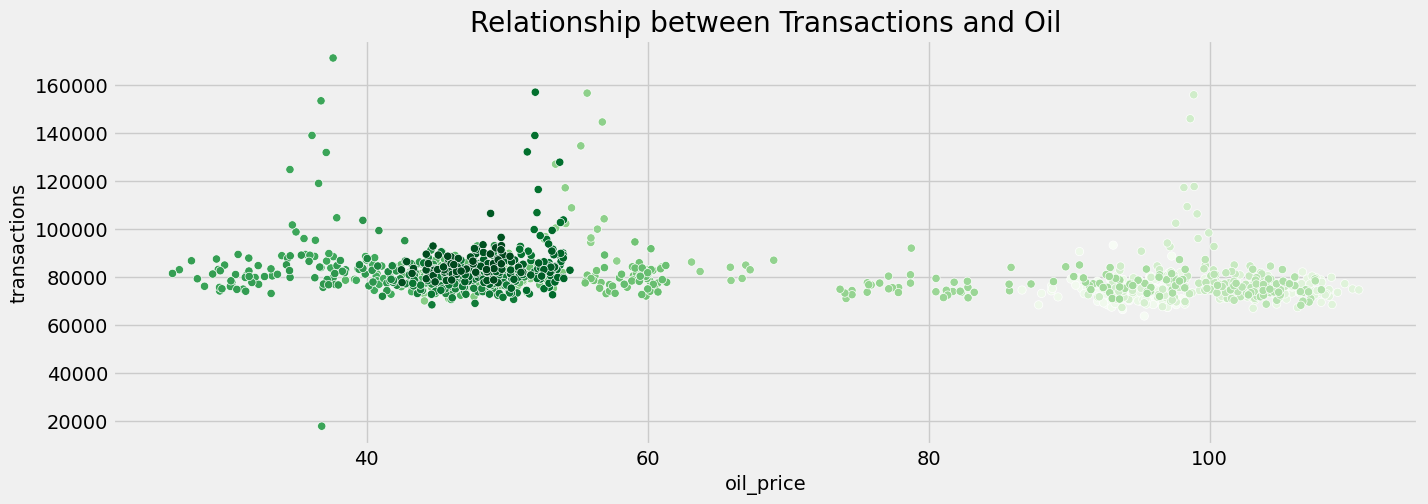

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=Oil_Transactions, x="oil_price", y="transactions", palette="Greens", hue="date",
                legend=False)
plt.title("Relationship between Transactions and Oil")
plt.show()


The relationship between oil and transaction is stationary. A change in oil price does not necessarily calls for a change in transactions at the stores. However, there are some outlier values which may be caused other factors such as the holiday seasons 

### ANALYSIS

### Question 1
Is the train dataset complete

In [ ]:
missing_date = pd.date_range(start="2013-01-01", end="2017-08-15").difference(train.date)
list(missing_date)

[Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')]

We can realize that 25th December of 2013, 2014, 2015 and 2016 are missing

####  Question 2
Which dates have the lowest and highest sales for each year?

### Question 3
 Did the earthquake impact sales? (april 16, 2016) 

In [ ]:
#converting to same datatype
train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

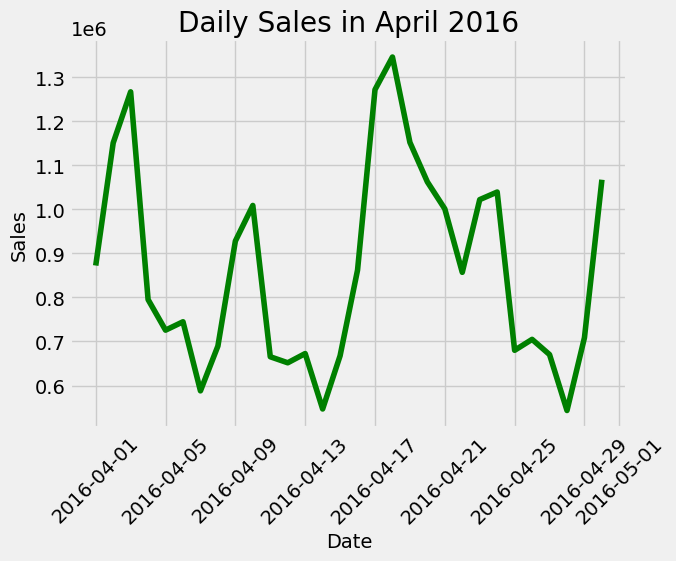

In [ ]:
sales_df = pd.merge(train, transactions, on=['date', 'store_nbr'])
april_sales = sales_df[(sales_df['date'] >= '2016-04-01') & (sales_df['date'] <= '2016-04-30')]
daily_sales = april_sales.groupby('date')['sales'].sum()
plt.plot(daily_sales.index, daily_sales.values, color="green")
plt.title('Daily Sales in April 2016')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

## FEATURE PROCESSING AND ENGINEERING

### Merging all datasets into a single dataset

In [ ]:
#Merging the dataset
df = train.merge(stores, on='store_nbr').merge(transactions, on=['date', 'store_nbr']).merge(holidays, on='date').merge(oil, on='date')


In [ ]:
df.to_csv(df, index=False)

TypeError: argument of type 'method' is not iterable

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import os, pickle
import sklearn
from sklearn.linear_model import LinearRegression
import sklearn
import datetime
from sklearn.model_selection import GridSearchCV
import sklearn
from scipy import interpolate
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.correlation_tools import corr_nearest
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pmdarima
from pmdarima import auto_arima
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
#loading and merging all dataset
test=pd.read_csv("test.csv")
merge_data=pd.read_csv('df.csv')
merge_data

,date,dcoilwtico,family,holiday_type,id,onpromotion,sales,store_nbr,transactions,transferred
0,2013-02-11,97.01,AUTOMOTIVE,D,0.0,0,0.0,1,396.0,False
1,2013-02-11,97.01,BABY CARE,D,0.0,0,0.0,1,396.0,False
2,2013-02-11,97.01,BEAUTY,D,0.0,0,0.0,1,396.0,False
3,2013-02-11,97.01,BEVERAGES,D,0.0,0,172.0,1,396.0,False
4,2013-02-11,97.01,BOOKS,D,0.0,0,0.0,1,396.0,False
...,...,...,...,...,...,...,...,...,...,...
350554,2017-08-31,47.57,POULTRY,Normal,3029395.0,1,0.0,9,0.0,False
350555,2017-08-31,47.57,PREPARED FOODS,Normal,3029396.0,0,0.0,9,0.0,False
350556,2017-08-31,47.57,PRODUCE,Normal,3029397.0,1,0.0,9,0.0,False
350557,2017-08-31,47.57,SCHOOL AND OFFICE SUPPLIES,Normal,3029398.0,9,0.0,9,0.0,False


In [ ]:
#adding the test data to the main dataset
df=pd.concat([merge_data, test], sort=True)
df

,date,dcoilwtico,family,holiday_type,id,onpromotion,sales,store_nbr,transactions,transferred
0,2013-02-11,97.01,AUTOMOTIVE,D,0.0,0,0.0,1,396.0,False
1,2013-02-11,97.01,BABY CARE,D,0.0,0,0.0,1,396.0,False
2,2013-02-11,97.01,BEAUTY,D,0.0,0,0.0,1,396.0,False
3,2013-02-11,97.01,BEVERAGES,D,0.0,0,172.0,1,396.0,False
4,2013-02-11,97.01,BOOKS,D,0.0,0,0.0,1,396.0,False
...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,NaN,POULTRY,NaN,3029395.0,1,NaN,9,NaN,NaN
28508,2017-08-31,NaN,PREPARED FOODS,NaN,3029396.0,0,NaN,9,NaN,NaN
28509,2017-08-31,NaN,PRODUCE,NaN,3029397.0,1,NaN,9,NaN,NaN
28510,2017-08-31,NaN,SCHOOL AND OFFICE SUPPLIES,NaN,3029398.0,9,NaN,9,NaN,NaN


In [ ]:
#checking the info of the merge dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379071 entries, 0 to 28511
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          379071 non-null  object 
 1   dcoilwtico    350559 non-null  float64
 2   family        379071 non-null  object 
 3   holiday_type  350559 non-null  object 
 4   id            379071 non-null  float64
 5   onpromotion   379071 non-null  int64  
 6   sales         350559 non-null  float64
 7   store_nbr     379071 non-null  int64  
 8   transactions  350559 non-null  float64
 9   transferred   350559 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 31.8+ MB


In [ ]:
# Use front fill to subsequent NaN values

df["dcoilwtico"].fillna(method = "ffill", inplace=True)

In [ ]:
# Use back fill to fill preceeding NaN values

df["dcoilwtico"].fillna(method = "bfill", inplace=True)

In [ ]:
# Use 0 to fill NaNvalues in the transactions column


df["transactions"] = df["transactions"].fillna(0)

In [ ]:
# Fill False to fill NaN values in the transferred colum

df["transferred"] = df["transferred"].fillna(False)

In [ ]:
# Use 0 to fill NaNvalues in the transactions column


df["sales"] = df["sales"].fillna(0)

In [ ]:
# Use 0 to fill NaNvalues in the transactions column


df["id"] = df["id"].fillna(0)

In [ ]:
# Use 0 to fill NaNvalues in the transactions column

df["holiday_type"] = df["holiday_type"].fillna('Normal')

In [ ]:
#checking for null values
df.isnull().sum()

date            0
dcoilwtico      0
family          0
holiday_type    0
id              0
onpromotion     0
sales           0
store_nbr       0
transactions    0
transferred     0
dtype: int64

In [ ]:
#feature creation
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['weekofyear'] = df['date'].dt.weekofyear

In [ ]:
#converting datetime values in the "date" column of a pandas DataFrame to Unix timestamps in float format.
df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).timestamp()).astype(float)


In [ ]:
import category_encoders as ce

# create the binary encoder object
encoder = ce.BinaryEncoder(cols=['family', 'holiday_type', 'transferred'])

# apply the encoding to the DataFrame
df_encoded = encoder.fit_transform(df)


In [ ]:
df=df_encoded

In [ ]:
df.shape

(379071, 23)

### Splitting of the dataset 

In [ ]:
X=df.iloc[:,0:12]
y=df.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split

# X is your feature data and y is your target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#setting date as index
X_train.set_index('date', inplace=True)
X_test.set_index('date', inplace=True)

In [ ]:
#cross checking for null values in the test dataset 
X_test.isnull().sum()

dcoilwtico        0
family_0          0
family_1          0
family_2          0
family_3          0
family_4          0
family_5          0
holiday_type_0    0
holiday_type_1    0
holiday_type_2    0
id                0
dtype: int64

### Linear Regression

In [ ]:
#training the model using Linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
#fitting the model
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)


In [ ]:
#printing the prediction 
print('Model score:', score)

Model score: 0.011742590849760037


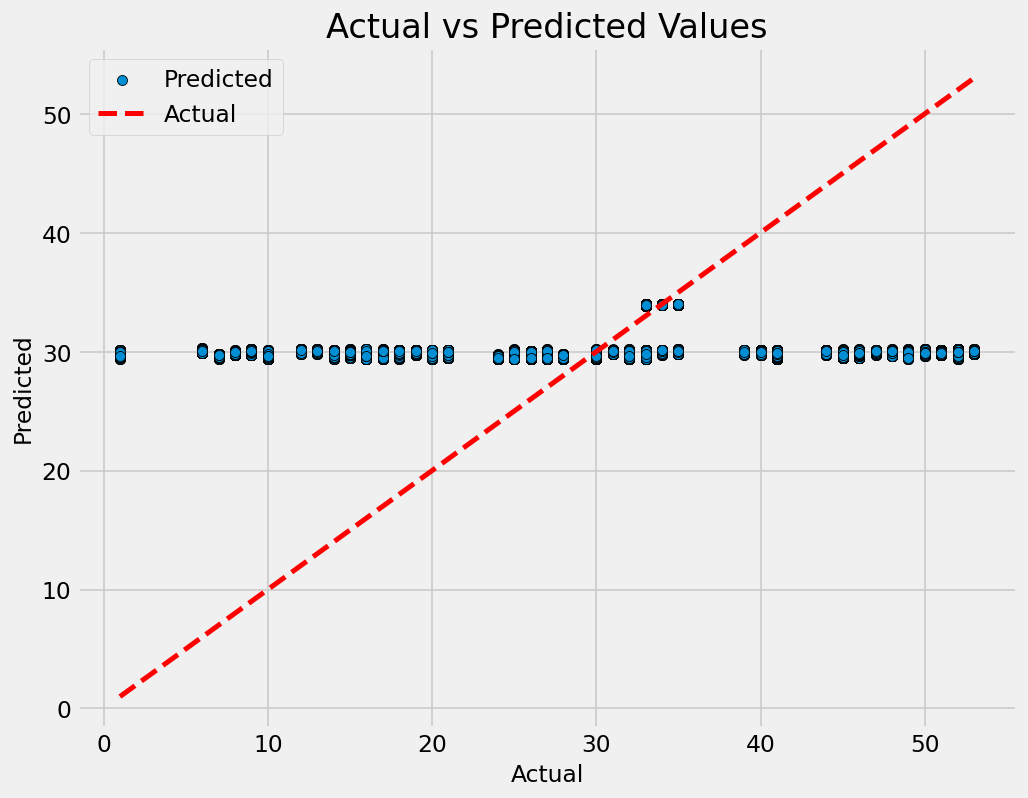

In [ ]:
#ploting actual vs predicted values 
import matplotlib.pyplot as plt

# Plot the actual and predicted values
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0), label='Predicted')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Actual')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted Values')
ax.legend()
plt.show()

### Evaluating the Linear Regression Model¶

In [ ]:
# Evaluating the models 
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
#Evaluating the model

import numpy as np

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test, y_pred)
rmsle = np.sqrt(msle)
print("MSE: {:.3f}".format(mse))
print("RMSE: {:.3f}".format(rmse))
print("MSLE: {:.3f}".format(msle))
print("RMSLE: {:.3f}".format(rmsle))


MSE: 177.218
RMSE: 13.312
MSLE: 0.352
RMSLE: 0.593


In [ ]:
df1 = pd.DataFrame([['Linear', mse,rmse,msle,rmsle]], columns= ['model', 'MSE','RMSE', 'MSLE', 'RMSLE'])
df1

,model,MSE,RMSE,MSLE,RMSLE
0,Linear,177.217831,13.312319,0.351781,0.593111


### Random Forest model

In [ ]:
#importing the libraries for Random forest model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


In [ ]:
#fitting the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
#predicting the test data
y_pred = rf.predict(X_test)


### Evaluating the Random forest model

In [ ]:
#importing the modules for evaluation
from sklearn.metrics import mean_squared_error, mean_squared_log_error

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
msle = mean_squared_log_error(y_test, y_pred)
rmsle = mean_squared_log_error(y_test, y_pred, squared=False)

print("MSE:", mse)
print("RMSE:", rmse)
print("MSLE:", msle)
print("RMSLE:", rmsle)


MSE: 44.52342878106347
RMSE: 6.672587862371201
MSLE: 0.11747300370477808
RMSLE: 0.34274334961422387


In [ ]:
#printing metrics
df2 = pd.DataFrame([['Random', mse,rmse,msle,rmsle]], columns= ['model', 'MSE','RMSE', 'MSLE', 'RMSLE'])
df2

,model,MSE,RMSE,MSLE,RMSLE
0,Random,44.523429,6.672588,0.117473,0.342743


### GradientBoostingRegressor

In [ ]:
#importing modules
from sklearn.ensemble import GradientBoostingRegressor

# Define the GBM model
gbm = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)


In [ ]:
# Train the GBM model
gbm.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=5, random_state=42)

In [ ]:
#prediction
y_pred = gbm.predict(X_test)
y_pred

array([24.1043333 , 23.09826646, 19.0660721 , ..., 26.53651835,
       33.32792887, 26.64882016])

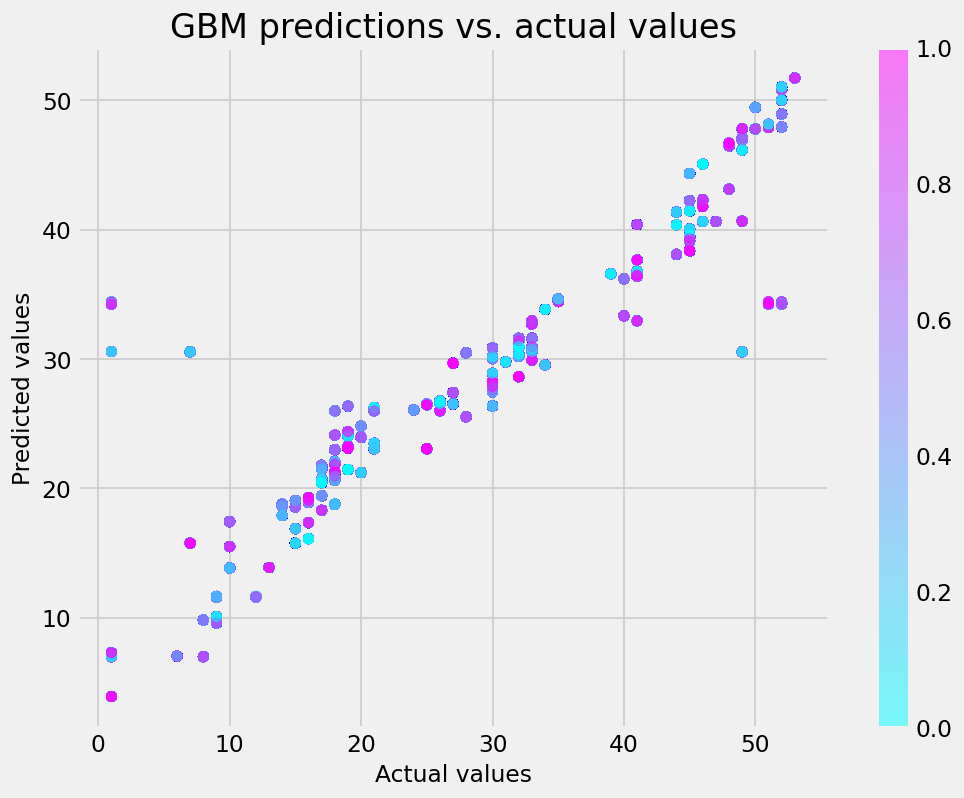

In [ ]:
# Create a boolean array that identifies actual values (True) and predicted values (False)
is_actual = np.ones(len(y_test), dtype=bool)
is_actual[::2] = False  # alternate True and False values

# Plot the predicted values against the actual values
plt.scatter(y_test, y_pred, c=is_actual, cmap='cool', alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('GBM predictions vs. actual values')
plt.colorbar()
plt.show()

### Evaluating the model

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

In [ ]:
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE:", rmsle)

RMSLE: 0.2892487039538244


In [ ]:
Results = pd.DataFrame([['Gradient', mse,rmse,msle,rmsle]], columns= ['model', 'MSE','RMSE', 'MSLE', 'RMSLE'])
Results

,model,MSE,RMSE,MSLE,RMSLE
0,Gradient,20.351318,4.511243,0.117473,0.289249


### Evaluation meterics for the three models 

In [ ]:


data = {
    'MSE': [20.351318, 44.523429, 177.217831],
    'RMSE': [4.511243, 6.672588, 13.312319],
    'MSLE': [0.117473, 0.117473, 0.351781],
    'RMSLE': [0.289249, 0.382648, 0.593111]
}

index = ['Gradient', 'Random', 'Linear']

metrics = pd.DataFrame(data=data, index=index)

print(metrics)


                 MSE       RMSE      MSLE     RMSLE
Gradient   20.351318   4.511243  0.117473  0.289249
Random     44.523429   6.672588  0.117473  0.382648
Linear    177.217831  13.312319  0.351781  0.593111
